# An example showcasing the usage of EllipticalSliceSampling.jl with AbstractGPs.jl

Loading the necessary packages.

In [1]:
using AbstractGPs, KernelFunctions, Plots
include("utils.jl")

Loading [toy regression dataset](https://github.com/GPflow/docs/blob/master/doc/source/notebooks/basics/data/regression_1D.csv) taken from GPFlow examples.

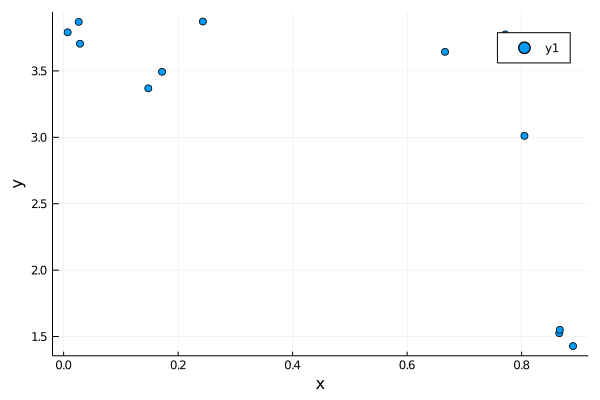

In [2]:
x = [0.8658165855998895, 0.6661700880180962, 0.8049218148148531, 0.7714303440386239, 0.14790478354654835, 0.8666105548197428, 0.007044577166530286, 0.026331737288148638, 0.17188596617099916, 0.8897812990554013, 0.24323574561119998, 0.028590102134105955];
y = [1.5255314337144372, 3.6434202968230003, 3.010885733911661, 3.774442382979625, 3.3687639483798324, 1.5506452040608503, 3.790447985799683, 3.8689707574953, 3.4933565751758713, 1.4284538820635841, 3.8715350915692364, 3.7045949061144983];
scatter(x, y, xlabel="x", ylabel="y")

Making a custom kernel with two parameters.

In [3]:
k = ScaledKernel(transform(Matern52Kernel(), ScaleTransform(1.0)), 1.0)

Matern 5/2 Kernel
	- Scale Transform (s = 1.0)
	- σ² = 1.0

Instantiating a Gaussian Process with the given kernel `k`.

In [4]:
f = GP(k)

GP{AbstractGPs.ZeroMean{Float64},ScaledKernel{TransformedKernel{Matern52Kernel,ScaleTransform{Float64}},Float64}}(AbstractGPs.ZeroMean{Float64}(), Matern 5/2 Kernel
	- Scale Transform (s = 1.0)
	- σ² = 1.0)

Instantiating a `FiniteGP`, a finite dimentional projection at the inputs of the dataset observed under Gaussian Noise with $\sigma = 0.001$ .

In [5]:
fx = f(x, 0.001)

AbstractGPs.FiniteGP{GP{AbstractGPs.ZeroMean{Float64},ScaledKernel{TransformedKernel{Matern52Kernel,ScaleTransform{Float64}},Float64}},Array{Float64,1},LinearAlgebra.Diagonal{Float64,FillArrays.Fill{Float64,1,Tuple{Base.OneTo{Int64}}}}}(
f: GP{AbstractGPs.ZeroMean{Float64},ScaledKernel{TransformedKernel{Matern52Kernel,ScaleTransform{Float64}},Float64}}(AbstractGPs.ZeroMean{Float64}(), Matern 5/2 Kernel
	- Scale Transform (s = 1.0)
	- σ² = 1.0)
x: [0.8658165855998895, 0.6661700880180962, 0.8049218148148531, 0.7714303440386239, 0.14790478354654835, 0.8666105548197428, 0.007044577166530286, 0.026331737288148638, 0.17188596617099916, 0.8897812990554013, 0.24323574561119998, 0.028590102134105955]
Σy: [0.001 0.0 … 0.0 0.0; 0.0 0.001 … 0.0 0.0; … ; 0.0 0.0 … 0.001 0.0; 0.0 0.0 … 0.0 0.001]
)


Data's log-likelihood w.r.t prior `GP`. 

In [6]:
logpdf(fx, y)

-564.1301705928381

Calculating the exact posterior with the given expected output `y` and `FiniteGP`. THe GP's kernel currently has fixed parameters. 

In [7]:
p_fx = posterior(fx, y)

AbstractGPs.PosteriorGP{GP{AbstractGPs.ZeroMean{Float64},ScaledKernel{TransformedKernel{Matern52Kernel,ScaleTransform{Float64}},Float64}},NamedTuple{(:α, :C, :x, :δ),Tuple{Array{Float64,1},LinearAlgebra.Cholesky{Float64,Array{Float64,2}},Array{Float64,1},Array{Float64,1}}}}(GP{AbstractGPs.ZeroMean{Float64},ScaledKernel{TransformedKernel{Matern52Kernel,ScaleTransform{Float64}},Float64}}(AbstractGPs.ZeroMean{Float64}(), Matern 5/2 Kernel
	- Scale Transform (s = 1.0)
	- σ² = 1.0), (α = [-292.44013483256657, -347.7911887102504, 258.1764428839332, 601.4218175346504, -209.01971088561947, -254.02494040374435, 11.614438442857718, 136.4414336548117, -92.5758532536271, 20.854960527167545, 189.974292449732, -22.760313113811847], C = LinearAlgebra.Cholesky{Float64,Array{Float64,2}}([1.000499875062461 0.9676113909702448 … 0.7547370752146634 0.6210984576509078; 0.9680950757747441 0.2544173658865052 … 0.5550748068413561 0.5693755166877438; … ; 0.755114349457278 0.8715128613918133 … 0.0473873513031849

Data's log-likelihood w.r.t exact posterior `GP`. We see that it drastically increases.

In [8]:
logpdf(p_fx(x), y)

-1.2851394200764766e7

Plotting the functions sampled from the exact posterior `p_fx` along with the data points.

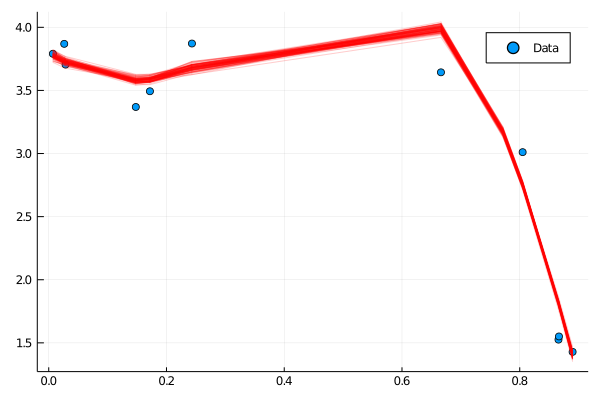

In [9]:
plt = scatter(x, y, label = "Data")
sampleplot!(plt, p_fx(sort(x), 0.001), 100, alph=0.1)

# Elliptical Slice Sampler

Previously, we computed the the exact posterior GP without tuning the kernel parameters and achieved a loglikelihood on exact posterior of $-1.285$. We now attempt get a better posterior by sampling for kernel parameters using Elliptical Slice Sampler provided by [EllipticalSliceSampling.jl](https://github.com/TuringLang/EllipticalSliceSampling.jl/)

We start of by loading necessary packages.

In [10]:
using EllipticalSliceSampling, Distributions

We define a function which returns log-likelihood of of data w.r.t an exact posterior with given set of kernel parameters.

In [11]:
function logp(params)
    exp_params = exp.(params)
    kernel = ScaledKernel(transform(Matern52Kernel(), ScaleTransform(exp_params[1])), exp_params[2])
    f = GP(kernel)
    fx = f(x, 0.1)
    p_fx = posterior(fx, y)
    return logpdf(p_fx(x, 0.1), y)
end

logp (generic function with 1 method)

We define a Gaussian prior over the joint distribution on kernel parameters space. Since we have only two parameters, we define a multi-variate Gaussian of dimension two.

In [12]:
prior = MvNormal(2, 1)

ZeroMeanIsoNormal(
dim: 2
μ: [0.0, 0.0]
Σ: [1.0 0.0; 0.0 1.0]
)


Sanity check for the defined `logp` function and `prior` distribution.

In [13]:
logp(rand(prior))

-8.539189949468275

Sampling 2,000 samples using `ESS_mcmc` provided by `EllipticalSliceSampling.jl`. 

In [14]:
samples = ESS_mcmc(prior, logp, 2_000);
samples_mat = hcat(samples...)';

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01


Plotting a histogram of the samples for the two parameters. The vertical line in each graph indicates the mean of the samples.

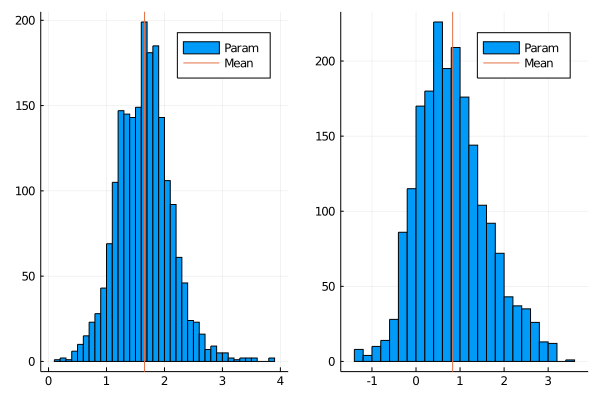

In [15]:
plt = histogram(samples_mat, layout=2, labels= "Param")
vline!(plt, mean(samples_mat, dims=1), layout=2, label="Mean")

Mean of samples of both the parameters.

In [16]:
mean_params = mean(samples_mat, dims=1)

1×2 Array{Float64,2}:
 1.65618  0.831459

Conditional log-probability of exact posterior with kernel's parameters tuned using ESS. We can observe that there is significant improvement over exact posterior with default kernel parameters. 

In [17]:
logp(mean_params)

-0.14765478051003544

Plotting sampled functions from posterior with tuned parameters

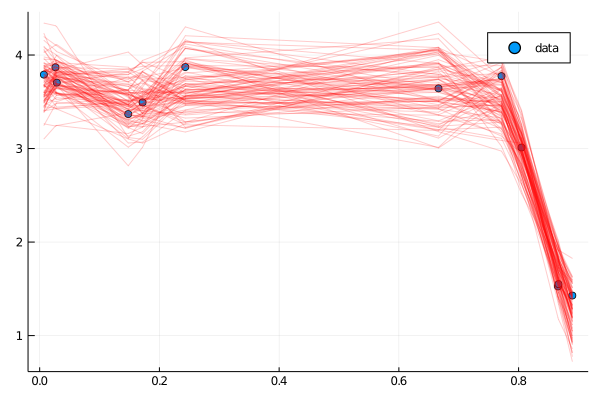

In [18]:

plt = scatter(x, y, label="data")

exp_mean_params = exp.(mean_params)
kernel = ScaledKernel(transform(Matern52Kernel(), ScaleTransform(exp_mean_params[1])), exp_mean_params[2])
f = GP(kernel)
fx = f(x, 0.1)
p_fx = posterior(fx, y)
sampleplot!(plt, p_fx(sort(x), 0.001), 100, alph=0.1)
plt